In [2]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2


### Load the FER2013 dataset


In [3]:
data = pd.read_csv("fer2013.csv")
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


### Split the data into training, validation, and test sets

In [4]:
train_data = data[data.Usage == "Training"]
validation_data = data[data.Usage == "PublicTest"]
test_data = data[data.Usage == "PrivateTest"]

### Convert the data to numpy arrays

In [5]:
x_train = np.array([np.fromstring(image, np.uint8, sep=' ') for image in train_data.pixels])
y_train = np.array(train_data.emotion)
x_val = np.array([np.fromstring(image, np.uint8, sep=' ') for image in validation_data.pixels])
y_val = np.array(validation_data.emotion)
x_test = np.array([np.fromstring(image, np.uint8, sep=' ') for image in test_data.pixels])
y_test = np.array(test_data.emotion)

(28709, 2304)

## Reshape the data to 244x244 images

In [10]:
x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_val = x_val.reshape(x_val.shape[0], 48, 48, 1)
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)

### Normalize the data

In [6]:
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
x_test = x_test.astype('float32') / 255

### One-hot encode the labels

In [7]:
num_classes = 7
y_train = np_utils.to_categorical(y_train, num_classes)
y_val = np_utils.to_categorical(y_val, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

### Data augmentation

In [8]:
data_gen = ImageDataGenerator(rotation_range=10, zoom_range=0.1, width_shift_range=0.1,
                              height_shift_range=0.1, horizontal_flip=True, fill_mode='nearest')
data_gen.fit(x_train)

### Define the model

In [9]:
# Define the model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


### Compile the model

In [10]:

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

### Define a callback to save the best model

In [11]:
checkpointer = ModelCheckpoint(filepath='model2.h5', save_best_only=True)

### Train the model

In [12]:
model.fit_generator(data_gen.flow(x_train, y_train, batch_size=32), steps_per_epoch=len(x_train) / 32,
                    epochs=20, validation_data=(x_val, y_val), callbacks=[checkpointer])

Epoch 1/20


C:\TEMP\ipykernel_10580\2286910557.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(data_gen.flow(x_train, y_train, batch_size=32), steps_per_epoch=len(x_train) / 32,


897/897 [==============================] - 25s 28ms/step - loss: 1.7829 - accuracy: 0.2653 - val_loss: 1.6793 - val_accuracy: 0.3305
Epoch 2/20
897/897 [==============================] - 25s 28ms/step - loss: 1.7109 - accuracy: 0.3118 - val_loss: 1.6107 - val_accuracy: 0.3798
Epoch 3/20
897/897 [==============================] - 25s 28ms/step - loss: 1.6489 - accuracy: 0.3472 - val_loss: 1.4756 - val_accuracy: 0.4310
Epoch 4/20
897/897 [==============================] - 23s 25ms/step - loss: 1.6024 - accuracy: 0.3728 - val_loss: 1.4379 - val_accuracy: 0.4394
Epoch 5/20
897/897 [==============================] - 23s 25ms/step - loss: 1.5628 - accuracy: 0.3883 - val_loss: 1.4413 - val_accuracy: 0.4600
Epoch 6/20
897/897 [==============================] - 23s 25ms/step - loss: 1.5408 - accuracy: 0.3996 - val_loss: 1.3804 - val_accuracy: 0.4759
Epoch 7/20
897/897 [==============================] - 23s 25ms/step - loss: 1.5185 - accuracy: 0.4101 - val_loss: 1.3742 - val_accuracy: 0.4784
Epo

### Evaluate the model on the test set

In [13]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.2428529262542725
Test accuracy: 0.522986888885498


### Select a few images from the test set

In [17]:
num_images = 5
random_indices = np.random.randint(x_test.shape[0], size=num_images)
test_images = x_test[random_indices]
test_labels = y_test[random_indices]

### Use the model to predict the emotions for the selected images

In [18]:
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

1/1 [==============================] - 0s 16ms/step


### Display the images and the predicted emotions

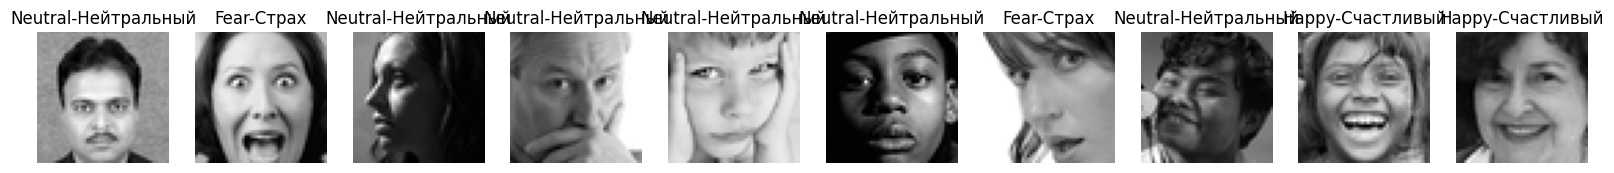

In [19]:
emotion_labels = {
    0: 'Angry-Злой',
    1: 'Disgust-Отвращение',
    2: 'Fear-Страх',
    3: 'Happy-Счастливый',
    4: 'Sad-Грустно',
    5: 'Surprise-Сюрприз',
    6: 'Neutral-Нейтральный'
}

fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
for i in range(num_images):
    ax = axes[i]
    ax.imshow(test_images[i, :, :, 0], cmap='gray')
    ax.axis('off')
    ax.set_title(emotion_labels[predicted_labels[i]])
plt.show()